# Hello, _nbpresent_!

In [ ]:
import nbpresent
nbpresent.__version__

# Deep Learning for NSL KDD dataset

> NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in [1]. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods...
> - Data files  
>     * KDDTrain+.ARFF: The full NSL-KDD train set with binary labels in ARFF format  
>     * KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format  
>     * KDDTrain+_20Percent.ARFF: A 20% subset of the KDDTrain+.arff file  
>     * KDDTrain+_20Percent.TXT: A 20% subset of the KDDTrain+.txt file  
>     * KDDTest+.ARFF: The full NSL-KDD test set with binary labels in ARFF format  
>     * KDDTest+.TXT: The full NSL-KDD test set including attack-type labels and difficulty level in CSV format  
>     * KDDTest-21.ARFF: A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21  
>     * KDDTest-21.TXT: A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21  
> [[University of New Brunswick](http://www.unb.ca/cic/research/datasets/nsl.html)]  



NSL KDD dataset has large number of columns which doesn't have significant correlation to decide whether current network session is *Normal* or an *Attack*. We performed Linear modeling of data and found that **36% of columns** *(considering 1e-5 as threshold for p value)* are significant in creating models of the dataset. Hence, we believe Deep Learning architectures like AutoEncoders and GANs will be best suitable.

We have special interest GAN networks due to their ability of learning about the data distribution by generating the distribution itself. We believe this can be utilized to generate Attack data distribution to help the discriminator model learn better.




In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
import statsmodels.api as sm
kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
kdd_train_2labels_y = pd.read_pickle("dataset/kdd_train_2labels_y.pkl")
results = sm.OLS(kdd_train_2labels_y.iloc[0:1000], kdd_train_2labels.iloc[0:1000, :-2]).fit()
#results.summary()

# Exploratory Data Analysis

In order to understand the data, apart from other methods we used, below are the ones which helped most while training our deep network architectures.

## Feature Selection

We found that only 15 (out of 41) columns have P-values considering 1e-5 as threshold.   
However, there are important questions to be answered before we can decide to remove the remaininig columns from the model.
- Is 1e-5 threshold the right value? 
- Can values with higher P-value have some impact in the model to achieve higher percentage of accuracy. 

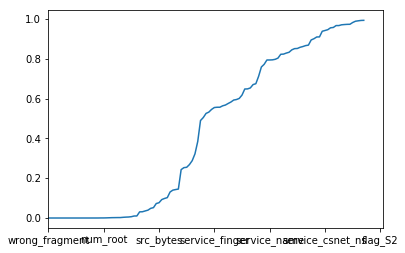

In [10]:
results.pvalues.sort_values().plot();

In [7]:
import warnings
warnings.filterwarnings('ignore')
print("Variables having P value lower than 1e-5")
results.pvalues[results.pvalues < 1e-5].sort_values()

Variables having P value lower than 1e-5


wrong_fragment                 1.577002e-39
same_srv_rate                  2.913320e-16
service_urp_i                  6.079849e-11
service_http                   1.801443e-10
dst_host_same_srv_rate         1.897631e-10
service_smtp                   2.699004e-10
dst_host_srv_rerror_rate       3.418082e-10
dst_host_srv_count             1.270372e-08
dst_host_same_src_port_rate    3.700446e-08
diff_srv_rate                  3.464595e-07
dst_host_srv_diff_host_rate    7.880064e-07
protocol_type_udp              1.163489e-06
service_IRC                    1.688161e-06
dst_host_count                 3.587908e-06
protocol_type_tcp              8.879575e-06
dtype: float64

## TSNE
- We found that Normal and Attack data are:
    * Not clearly seperable.
    * Not linearly sepearable 

![](images/TSNE-Train+Dataset.png)


In [11]:
#kdd_diff_level_train = pd.read_pickle("dataset/kdd_diff_level_train.pkl")
#kdd_diff_level_test = pd.read_pickle("dataset/kdd_diff_level_test.pkl")
#output_columns_2labels = ['Normal','Attack']
output_columns_2labels = ['Attack','Normal']
actual_value = pd.read_pickle("dataset/kdd_test_2labels_y.pkl");


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = True)

In [13]:
def get_count(pred_value):
    difficulty = pd.DataFrame({"Actual":actual_value, "Predict":pred_value, "difficulty_level":kdd_diff_level_test})
    #difficulty = pd.concat(difficulty, pd.Data)
    difficulty['accuracy'] = None
    difficulty.ix[difficulty.Actual == difficulty.Predict, "accuracy"] = 'Correct'
    difficulty.ix[difficulty.Actual != difficulty.Predict, "accuracy"] = 'Incorrect'
    diff_group = difficulty.loc[:,["difficulty_level", "accuracy", "Predict"]].groupby(["difficulty_level", "accuracy"])
    total_correct = sum(difficulty.Actual == difficulty.Predict)
    total_records = difficulty.shape[0]
    total_incorrect = total_records - total_correct
    print("Total Records:{}".format(total_records))
    return diff_group.count()

In [14]:
scores = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")
accumulate_test_scores = scores.iloc[:,0:3]
#accumulate_test_scores

In [15]:
def evaluate(pred_pkl, score_pkl, name = 'DNN'):
    global accumulate_test_scores
    predictions = pd.read_pickle(pred_pkl)
    scores = pd.read_pickle(score_pkl)
    
    accumulate_test_scores = pd.concat([accumulate_test_scores, 
                                        pd.DataFrame({"{}_test_score"
                                                                  .format(name):
                                                                  scores.loc[:,"test_score"]})], 
                                       axis = 1,)
    #accumulate_test_scores = accumulate_test_scores.rename(columns = {"test_score":"{}_test_score".format(name)})
    #print(scores.sort_values("test_score", ascending=False))

    df_sorted = scores.sort_values("test_score", ascending=False).iloc[0,0:3]
    epoch = int(df_sorted['epoch'])
    n_o_f = int(df_sorted['no_of_features'])
    h_l = int(df_sorted['hidden_layers'])
    print("Best model choosen is: Epochs:{} Number of Features:{} Hidden Layers:{}".format(epoch,n_o_f,h_l))
    df_pred = predictions["{}_{}_{}".format(epoch,n_o_f,h_l)] #.round(2)
    Attack_index = actual_value == 0
    Normal_index = actual_value == 1

    #df_pred[Attack_index].plot(kind='line', figsize=(20,5), title="Prediction of Attack")
    #df_pred[Normal_index].plot(kind='line', figsize=(20,5), title="Prediction of Normal")
    
    pred_value = df_pred["Prediction"] #np.argmax(df_pred.values, axis=1)
    plot(pred_value)
    return scores.sort_values("test_score", ascending=False)

# Evaluating Dense Network

![Fully Connected Network](images/NSL_KDD_FullyConnectedNetwork.jpg)

We used Fully connected Neural Network to observe the behavior of model training on NSL KDD data under various hyper parameter configurations as stated below:

- Feature Reduction  
We tried to reduce the number of features to understand how much the data can be compressed while still able to generalize enough for test dataset.
    
- Number of Hidden layers  
    We wanted to observe how many layers of dense networks may be required to capture the non-leanarity of the data. This understanding may prove useful while training other deep learning architectures.
- Epochs, learning rate   
    We wanted to get an understanding of how much time/resources will be required to train the model.

In [ ]:
evaluate("dataset/tf_dense_only_nsl_kdd_predictions.pkl",
         "dataset/tf_dense_only_nsl_kdd_scores.pkl", "DenseNetwork")

# Variational Autoencoders 

Variational Autoencoders can reduce the features by initially compressing the data and then calculating mean and variance of the compressed data features. Mean and variance is used to approximate data distribution (Z) of each compressed feature. The model learns by optimzing loss occured while reproducing the actual data using the Z data distribution.  

## Predict using Softmax
In order to predict whether current network session is Normal or Attack, we coupled Softmax with layer producing Z data distribution.

![VAE with Softmax](images/VAE_withSoftmax.jpg)


Best model choosen is: Epochs:100 Number of Features:32 Hidden Layers:2


,epoch,no_of_features,hidden_layers,train_score,test_score
3,100,32,2,0.894503,0.909022
2,100,16,2,0.898035,0.906317
0,100,4,2,0.867156,0.885646
6,100,16,4,0.911649,0.877883
5,100,8,4,0.926057,0.871984
10,100,16,6,0.849097,0.867504
4,100,4,4,0.829927,0.861870
9,100,8,6,0.909268,0.857567
1,100,8,2,0.826751,0.852244
11,100,32,6,0.945704,0.847853


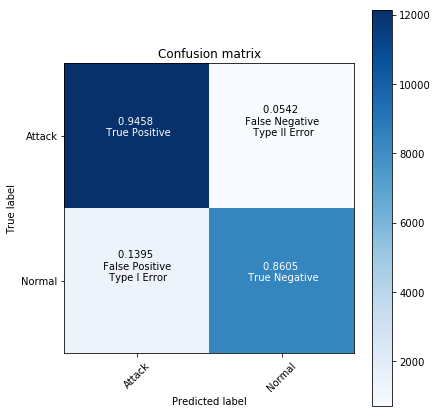

In [18]:
evaluate("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl",
         "dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl", "VAE_with_Softmax")

## Include dependent Variable as feature.

Another approach we took is to train VAE to reproduce Normal/Attack labels itself during Training cylce. While testing, we would replace the labels with **random values(0~1)** and use VAE to generate correct values of the labels.

![VAE with Softmax](images/VAE_withLabel.jpg)


## using VAE Loss

< explain the variation >

Best model choosen is: Epochs:100 Number of Features:4 Hidden Layers:4


,epoch,no_of_features,hidden_layers,train_score,test_score
4,100,4,4,0.905620,0.900506
8,100,4,6,0.862756,0.886622
9,100,8,6,0.852278,0.885291
11,100,32,6,0.920464,0.873137
5,100,8,4,0.887442,0.863911
10,100,16,6,0.931815,0.863290
7,100,32,4,0.886649,0.862092
6,100,16,4,0.919273,0.856148
3,100,32,2,0.939197,0.855438
0,100,4,2,0.917130,0.850603


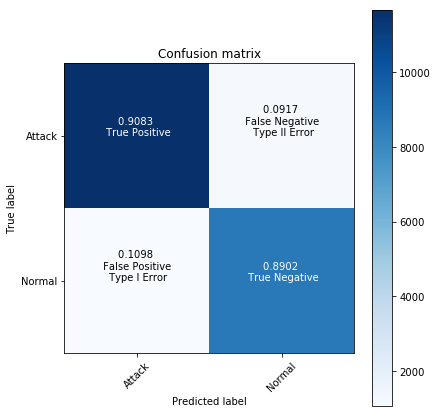

In [16]:
evaluate("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl",
         "dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl", "VAE_with_label")

## Using MSE Loss

Best model choosen is: Epochs:100 Number of Features:4 Hidden Layers:4


,epoch,no_of_features,hidden_layers,train_score,test_score
4,100,4,4,0.870694,0.902014
5,100,8,4,0.943880,0.888086
9,100,8,6,0.927766,0.866749
8,100,4,6,0.959994,0.843506
2,100,16,2,0.943562,0.837961
11,100,32,6,0.921337,0.837917
10,100,16,6,0.914351,0.836631
1,100,8,2,0.913161,0.832150
6,100,16,4,0.959438,0.823589
0,100,4,2,0.954517,0.821017


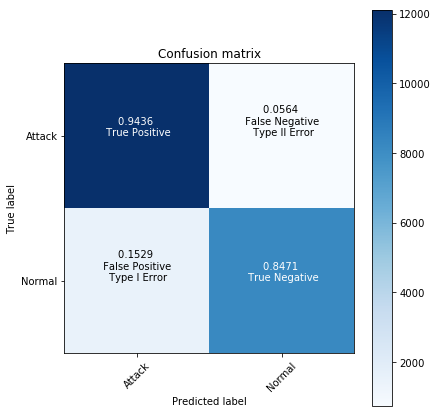

In [17]:
evaluate("dataset/tf_vae_only_nsl_kdd_predictions.pkl",
         "dataset/tf_vae_only_nsl_kdd_scores.pkl", "VAE_with_label_MSE_loss")

# LSTM Autoencoder Model

LSTM Autoencoder, aka Seq2Seq, model is generally used to predict sequences of numbers (time dependent) given another sequence of numbers. LSTM encoders generates a context vector using input sequence which is passed on to decoder to generate the output.  
We coupled LSTM decoder cells with Softmax layer to generate probability whether current session is Normal or Attack  


![LSTM Encoder Decoder Model](images/LSTMseq2seq_withsoftmax.jpg)

In [ ]:
#evaluate("dataset/keras_lstm_nsl_kdd_predictions.pkl",
#         "dataset/keras_lstm_nsl_kdd_scores.pkl", "VAE_with_label_MSE_loss")

## GANs - General Idea
![Generative Advarsarial Networks](images/NSL_KDD_GAN_original_idea.jpg)

## GANs - For Hypothesis testing

< explain the questions that needs to be asked >

![GANs for Hypothesis Testing](images/NSL_KDD_GAN_initial_state.jpg)

< explain how these questions can be answered >
![GAN_hypo_optim_state](images/NSL_KDD_GAN_hypo_optim_state.jpg)

### GANs for NSL KDD dataset 

< Explain how above architecture can be used >

![GANs for NSL KDD dataset ](images/NSL_KDD_GAN_attack_hypothesis.jpg)

# Compare Results

In [ ]:
accumulate_test_scores['param'] = accumulate_test_scores[['epoch','no_of_features', 'hidden_layers']].apply(lambda x : '{}_{}_{}'.format(x[0],x[1], x[2]), axis=1)

In [ ]:
accumulate_test_scores = accumulate_test_scores.drop(['epoch','no_of_features', 'hidden_layers'], axis = 1)

In [ ]:
accumulate_test_scores.set_index("param", inplace = True)

In [ ]:
accumulate_test_scores

In [ ]:
f = plt.figure()
accumulate_test_scores.plot(kind='bar', figsize=(15,4), ax=f.gca(),grid=True, )
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
accumulate_test_scores.to_csv("dataset/results.csv")